### EUR USD Moving Average Strategy 

@guzmanwolfrank on GitHub 


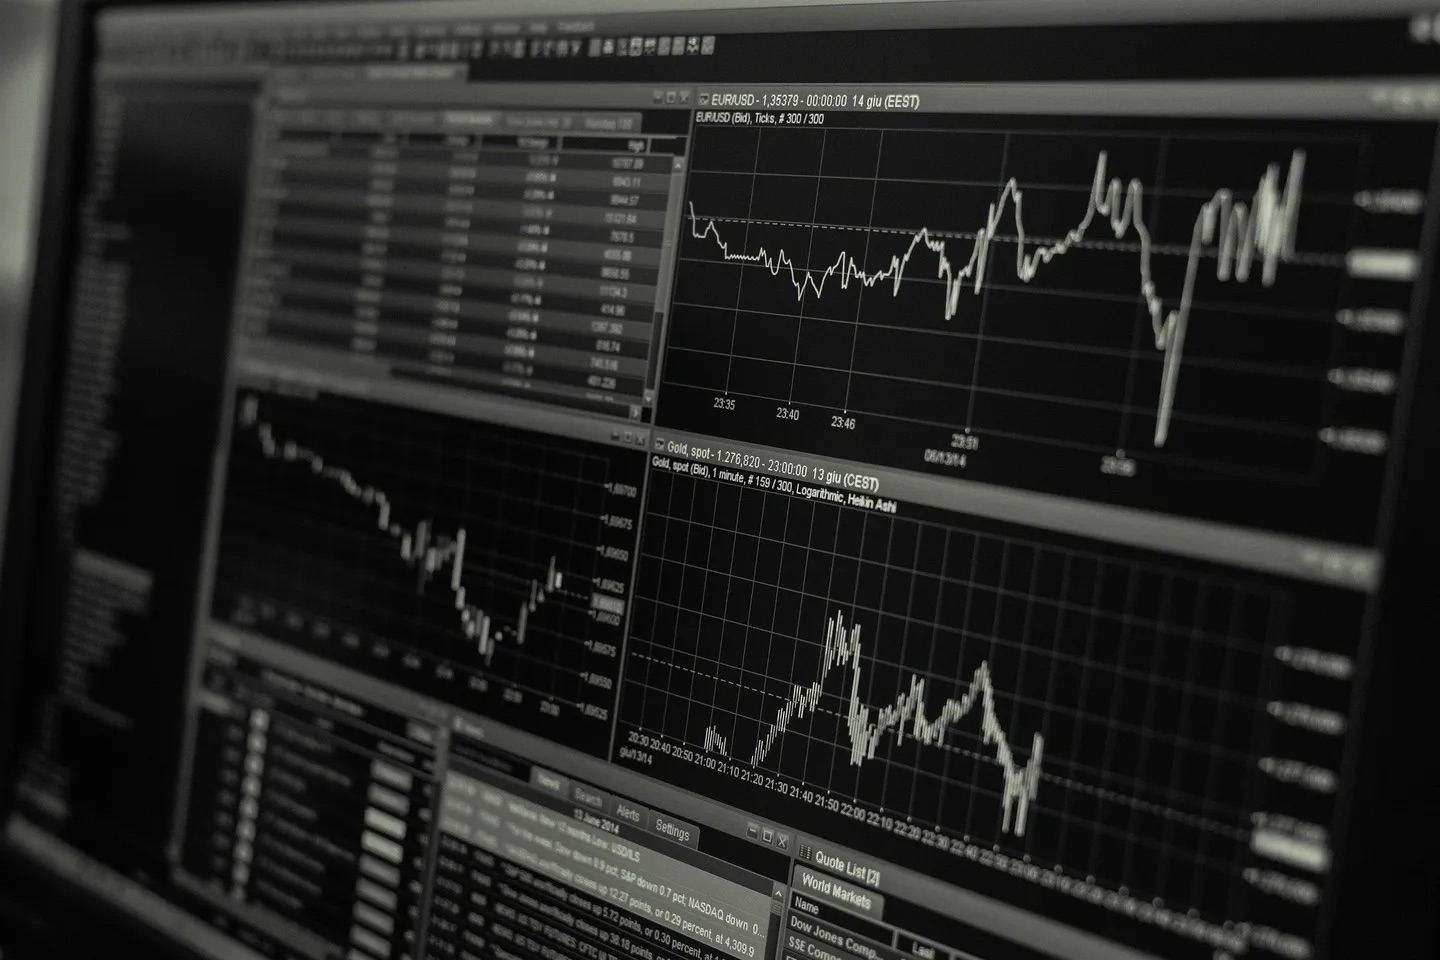

This project is intended to help a beginner start working on algorithms and backtests on simple quant strategies.  
We will be using a Forex Brokerage account as a Data Provider and its Python module as well. 

The strategy consists of buying on a signal that is triggered when the 10 day moving average is greater than the day's open. 

The transaction then occurs on the following day's open and close. 

Backtest and Transaction Details: 

        Currency Pair: EUR/USD 
#

        Account Balance: $ 10,000
        Leverage : 50X
        Average Order Size: 50,000
        Order Entry: Buy Market at Open
        Order Exit: Sell Market at Close
        Margin Used: $ 1,000
        Margin: 2%





We will run multiple iterations of the backtest through set dates in order to analyze the data and see if the strategy is worth pursuing. 

Let's begin by importing all our necessary modules. 



In [25]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
from datetime import datetime, timedelta
import time
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
# Ignore all warnings
warnings.filterwarnings('ignore')

In [26]:

# OANDA API credentials
api_token = '4774a622bc314440290f530efcc46453-eb96728988593ba944d5285fbcf8786a'
account_id = '101-001-8028197-001'

# OANDA API connection
api = oandapyV20.API(access_token=api_token)

In [27]:
# Download Data for Backtest 
client = oandapyV20.API(access_token=api_token)

# Get historical data for EURUSD
instrument = "EUR_USD"
start_date = "2010-06-01"
end_date = "2023-10-03"
params = {"from": start_date, "to": end_date, "granularity": "D"}
r = instruments.InstrumentsCandles(instrument=instrument, params=params)
candles = client.request(r)["candles"]

# Create a DataFrame from the historical data
df = pd.DataFrame([{"time": c["time"], "open": c["mid"]["o"], "high": c["mid"]["h"], "low": c["mid"]["l"], "close": c["mid"]["c"]} for c in candles])
df["time"] = pd.to_datetime(df["time"])

display(df)

,time,open,high,low,close
0,2010-05-31 21:00:00+00:00,1.23062,1.23540,1.21113,1.22289
1,2010-06-01 21:00:00+00:00,1.22279,1.22736,1.21756,1.22491
2,2010-06-02 21:00:00+00:00,1.22507,1.23264,1.21530,1.21621
3,2010-06-03 21:00:00+00:00,1.21624,1.22156,1.19562,1.19673
4,2010-06-04 21:00:00+00:00,1.19670,1.19678,1.19670,1.19678
...,...,...,...,...,...
3710,2023-09-26 21:00:00+00:00,1.05698,1.05743,1.04880,1.05026
3711,2023-09-27 21:00:00+00:00,1.05074,1.05790,1.04911,1.05664
3712,2023-09-28 21:00:00+00:00,1.05616,1.06171,1.05581,1.05744
3713,2023-10-01 21:00:00+00:00,1.05720,1.05919,1.04779,1.04780


In [28]:
# Calculate 10-day moving average of the open closes
df['MA10'] = df['open'].rolling(window=5).mean()

# Convert Data types for easy integration
df['MA10'] = df['MA10'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)

# Create a 'Signal' column indicating when the short moving average crosses the long.
df['Signal'] = np.where(df['open'] > df['MA10'], 1.0, 0.0)

# Create a new column named "Order", buy the day after (diff) when signal is generated, buy on the open, sell at the close! 
df["StratOrder"] = ""
StratOrder = df['StratOrder']
df.loc[df["Signal"] == 1.0, "StratOrder"] = "Buy"

df['Signal'] = 0  # 0 represents no signal
df.loc[df['open'] < df['MA10'], 'Signal'] = -1  # Sell signal
df.loc[df['open'] > df['MA10'], 'Signal'] = 1   # Buy signal

# Drop null values 
df = df.dropna()

In [29]:
display(df)

,time,open,high,low,close,MA10,Signal,StratOrder
4,2010-06-04 21:00:00+00:00,1.19670,1.19678,1.19670,1.19678,1.218284,-1,
5,2010-06-05 21:00:00+00:00,1.19678,1.19709,1.19239,1.19296,1.211516,-1,
6,2010-06-06 21:00:00+00:00,1.19299,1.19916,1.18765,1.19236,1.205556,-1,
7,2010-06-07 21:00:00+00:00,1.19239,1.20092,1.19018,1.19731,1.199020,-1,
8,2010-06-08 21:00:00+00:00,1.19740,1.20734,1.19242,1.19792,1.195252,1,Buy
...,...,...,...,...,...,...,...,...
3710,2023-09-26 21:00:00+00:00,1.05698,1.05743,1.04880,1.05026,1.062710,-1,
3711,2023-09-27 21:00:00+00:00,1.05074,1.05790,1.04911,1.05664,1.059676,-1,
3712,2023-09-28 21:00:00+00:00,1.05616,1.06171,1.05581,1.05744,1.057726,-1,
3713,2023-10-01 21:00:00+00:00,1.05720,1.05919,1.04779,1.04780,1.056074,1,Buy


In [30]:
# Filtering the DataFrame
buy_df = df[df['StratOrder'].isin(['Buy'])]
# Displaying the result
display(buy_df)

,time,open,high,low,close,MA10,Signal,StratOrder
8,2010-06-08 21:00:00+00:00,1.19740,1.20734,1.19242,1.19792,1.195252,1,Buy
9,2010-06-09 21:00:00+00:00,1.19782,1.21424,1.19572,1.21268,1.195476,1,Buy
10,2010-06-10 21:00:00+00:00,1.21284,1.21524,1.20452,1.21123,1.198688,1,Buy
11,2010-06-11 21:00:00+00:00,1.21118,1.21118,1.21118,1.21118,1.202326,1,Buy
12,2010-06-12 21:00:00+00:00,1.21111,1.21330,1.21079,1.21303,1.206070,1,Buy
...,...,...,...,...,...,...,...,...
3691,2023-08-30 21:00:00+00:00,1.09262,1.09398,1.08351,1.08434,1.084506,1,Buy
3699,2023-09-11 21:00:00+00:00,1.07492,1.07694,1.07056,1.07566,1.072284,1,Buy
3700,2023-09-12 21:00:00+00:00,1.07540,1.07650,1.07112,1.07298,1.072872,1,Buy
3705,2023-09-19 21:00:00+00:00,1.06816,1.07369,1.06502,1.06599,1.067994,1,Buy


In [31]:

# Find values in 'Open' and 'Close' columns in the row after 'Buy' in 'Strat Order'
buy_indices = df[df['StratOrder'] == 'Buy'].index

# Finds the next day to operate buy signal on!  Eureka! 
next_row_indices = buy_indices + 1
# Make the dataframe for next rows so we can calculate balance etc afterwards
nextday_df = df.loc[next_row_indices, ['time','open', 'close','high','low','MA10',]]
ndf = nextday_df


Now, let's add more columns to our filtered dataframe with all subsequent rows on which the transactions occur.  
This includes adding a benchmark study of a buy and hold strategy for comparison.  We will also add returns percentage and balances. 

In [32]:
# Create Delta column to gauge intraday change in close 
ndf['Delta']= ndf['close']-ndf['open']

# Create Range column to track distance between low and high 
ndf['Range']= ndf['high']-ndf['low']

# Create Unit Tradesize Column which is in units instead of dollars, longer explanation detailing margin, unit size, leverage etc. 
ndf['Unit Size']= 50000

# Create Tradesize 
ndf['Tradesize'] = ndf['Unit Size'] * ndf['close']

# Create Margin Used on particular trade 
ndf['Margin Used'] = .02 * ndf['Tradesize']

# Create the Strategy profit column using delta (intraday change) and unit size
ndf['StratProfit']= ndf['Delta'] * ndf['Unit Size']

# Define and Calculate Balance and Strat Initial Balance (the close at the open of first day trade)
SIB = 10000
cum_profit = ndf['StratProfit'].cumsum()
ndf['Strat_Balance'] = cum_profit  + SIB 
Strat_Balance = ndf['Strat_Balance']



# Win Loss Column added
def is_profitable(row):
    if row['StratProfit'] > 0:
        return 'Win'
    else:
        return 'Loss'

ndf['WinLoss'] = ndf.apply(is_profitable, axis=1)

# Add 'WIN' column to store positive profits
def get_win_amount(row):
    if row['StratProfit'] > 0:
        return row['StratProfit']
    else:
        return 0.00

ndf['Win'] = ndf.apply(get_win_amount, axis=1)

# Add 'Loss' column to store negative profits
def get_loss_amount(row):
    if row['StratProfit'] < 0:
        return row['StratProfit']
    else:
        return 0.00

ndf['Loss'] = ndf.apply(get_loss_amount, axis=1)

# Strategy Returns Column 
ndf['Strat_Returns_pct'] =((Strat_Balance/SIB) -1)*100
Strat_Returns = ndf['Strat_Returns_pct']

# Calculate the strat drawdown
stratdrawdown = ndf["Strat_Balance"].max() - ndf["Strat_Balance"]
ndf['StratDrawdown'] = stratdrawdown

# Buy and Hold as a Benchmark 
# Create bhBalance from shares * close 

bhBalance = 10000 * ndf['close']
ndf['bhBalance']= bhBalance

# Calculate the bh drawdown
drawdown = ndf["bhBalance"].max() - ndf["bhBalance"]
ndf['bhDrawdown'] = drawdown



# Buy and Hold Strategy Pct Return and Cumulative Strategy Pct Return 

# Define initial balance and strategy balance
initial_balance = 10000  # Example initial balance
bhbalance = ndf['bhBalance']    # Example strategy balance

# Calculate bnh return
bhreturnpct= ((bhbalance - initial_balance) / initial_balance)*100 


# Return is cumulative for bh strategy (buy and hold strategy)
ndf['bhreturnpct']=bhreturnpct 

display(ndf)



,time,open,close,high,low,MA10,Delta,Range,Unit Size,Tradesize,...,StratProfit,Strat_Balance,WinLoss,Win,Loss,Strat_Returns_pct,StratDrawdown,bhBalance,bhDrawdown,bhreturnpct
9,2010-06-09 21:00:00+00:00,1.19782,1.21268,1.21424,1.19572,1.195476,0.01486,0.01852,50000,60634.0,...,743.0,10743.0,Win,743.0,0.0,7.430,15135.0,12126.8,2703.3,21.268
10,2010-06-10 21:00:00+00:00,1.21284,1.21123,1.21524,1.20452,1.198688,-0.00161,0.01072,50000,60561.5,...,-80.5,10662.5,Loss,0.0,-80.5,6.625,15215.5,12112.3,2717.8,21.123
11,2010-06-11 21:00:00+00:00,1.21118,1.21118,1.21118,1.21118,1.202326,0.00000,0.00000,50000,60559.0,...,0.0,10662.5,Loss,0.0,0.0,6.625,15215.5,12111.8,2718.3,21.118
12,2010-06-12 21:00:00+00:00,1.21111,1.21303,1.21330,1.21079,1.206070,0.00192,0.00251,50000,60651.5,...,96.0,10758.5,Win,96.0,0.0,7.585,15119.5,12130.3,2699.8,21.303
13,2010-06-13 21:00:00+00:00,1.21295,1.22209,1.22986,1.21172,1.209180,0.00914,0.01814,50000,61104.5,...,457.0,11215.5,Win,457.0,0.0,12.155,14662.5,12220.9,2609.2,22.209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,2023-08-31 21:00:00+00:00,1.08413,1.07752,1.08822,1.07721,1.085124,-0.00661,0.01101,50000,53876.0,...,-330.5,20702.0,Loss,0.0,-330.5,107.020,5176.0,10775.2,4054.9,7.752
3700,2023-09-12 21:00:00+00:00,1.07540,1.07298,1.07650,1.07112,1.072872,-0.00242,0.00538,50000,53649.0,...,-121.0,20581.0,Loss,0.0,-121.0,105.810,5297.0,10729.8,4100.3,7.298
3701,2023-09-13 21:00:00+00:00,1.07292,1.06440,1.07523,1.06319,1.072968,-0.00852,0.01204,50000,53220.0,...,-426.0,20155.0,Loss,0.0,-426.0,101.550,5723.0,10644.0,4186.1,6.440
3706,2023-09-20 21:00:00+00:00,1.06591,1.06610,1.06736,1.06169,1.066592,0.00019,0.00567,50000,53305.0,...,9.5,20164.5,Win,9.5,0.0,101.645,5713.5,10661.0,4169.1,6.610


We have constructed all of our data and findings for our backtest. 

We can use this data and dataframe to answer the following questions:

        1.  What were the results of the strategy?
        2.  What was the drawdown?
        3.  How did the benchmark perform?
        4.  What were the risk metrics? 
        5.  What were the average profits? Losses?
        6.  What was the win/loss count?
        7.  What is the average daily range? 
        8.  What is the average daily change?
        9.  What is the rate of return on the strategy?
        10. What were the most and least profitable trades? 

1.  What were the results of the strategy? 

To answer this question we can print a seaborn chart with the strategy balance on a line chart. We can also describe the results. 

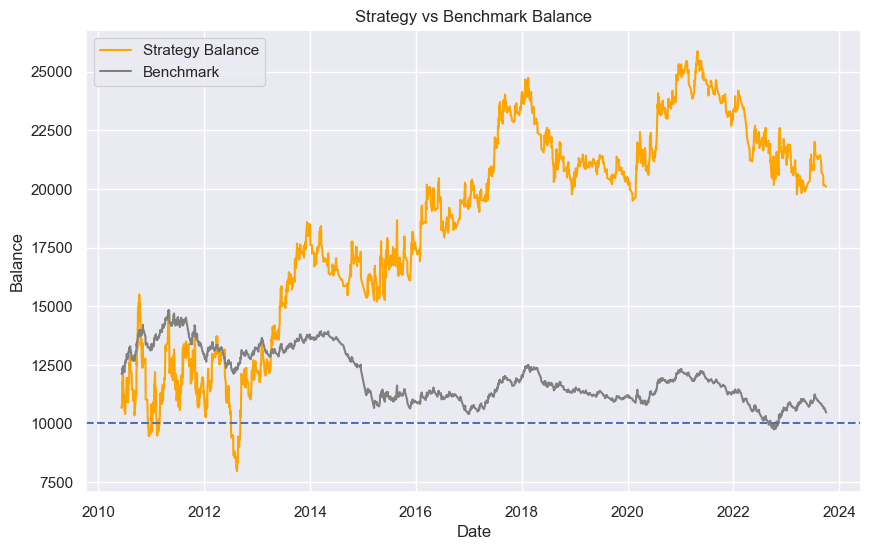

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
x_values = ndf['time']
y1_values = ndf['Strat_Balance']
y2_values = ndf['bhBalance']

# Create a DataFrame (optional, but often convenient)
import pandas as pd
df = pd.DataFrame({'X': x_values, 'Line1': y1_values, 'Line2': y2_values})

# Set the style of seaborn
sns.set(style="darkgrid")
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create a lineplot
sns.lineplot(data=df, x='X', y='Line1', label='Strategy Balance', color= 'orange')
sns.lineplot(data=df, x='X', y='Line2', label='Benchmark', color= 'grey')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Strategy vs Benchmark Balance')

# Show the legend
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=0)

horizontal_line_value = 10000  # Set the value for the horizontal line
plt.axhline(y=horizontal_line_value, color='b', linestyle='--', label='Starting Balance')

# Show the plot
plt.show()


Let's take a look at other metrics in the form of the 

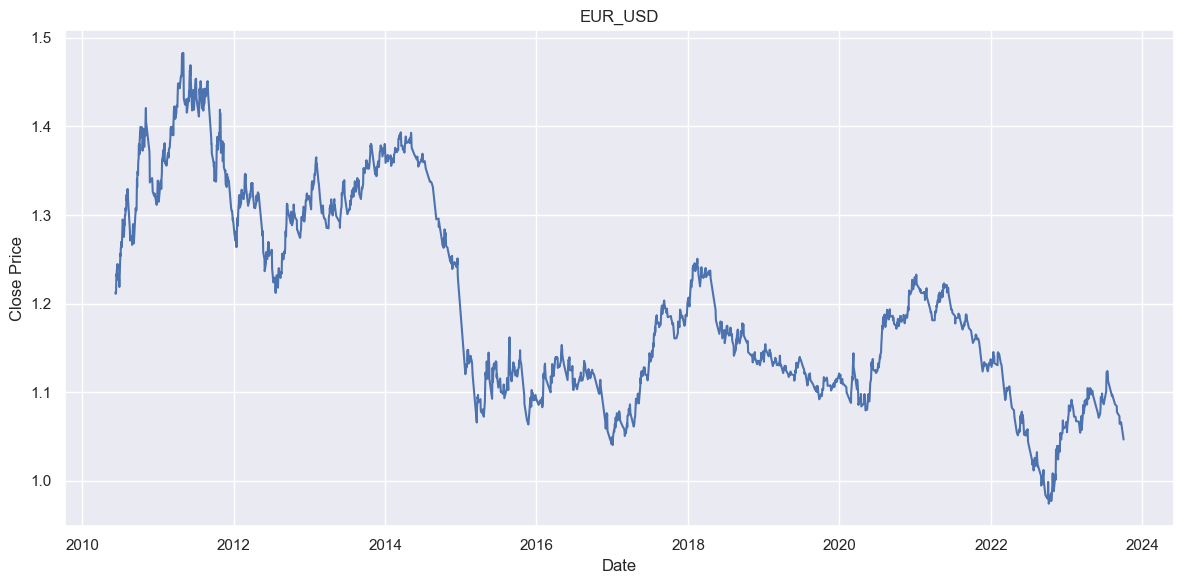

In [34]:

# Create a line chart using Seaborn
plt.figure(figsize=(12, 6))
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y="close", data=ndf)
plt.title("EUR_USD")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
display(ndf['StratProfit'].describe())


count    1845.000000
mean        5.476965
std       315.992800
min     -1443.000000
25%      -175.000000
50%         0.000000
75%       175.500000
max      1615.500000
Name: StratProfit, dtype: float64

In [36]:
display(ndf['Strat_Balance'].describe())


count     1845.000000
mean     17980.218157
std       4590.269744
min       7962.000000
25%      13276.500000
50%      19067.500000
75%      21627.500000
max      25878.000000
Name: Strat_Balance, dtype: float64

In [37]:
display(ndf['Win'].describe())


count    1845.000000
mean      117.294309
std       195.549985
min         0.000000
25%         0.000000
50%         0.000000
75%       175.500000
max      1615.500000
Name: Win, dtype: float64

In [38]:
display(ndf['Loss'].describe())


count    1845.000000
mean     -111.817344
std       188.059436
min     -1443.000000
25%      -175.000000
50%         0.000000
75%         0.000000
max         0.000000
Name: Loss, dtype: float64

In [39]:
display(ndf['Strat_Returns_pct'].describe())


count    1845.000000
mean       79.802182
std        45.902697
min       -20.380000
25%        32.765000
50%        90.675000
75%       116.275000
max       158.780000
Name: Strat_Returns_pct, dtype: float64

In [40]:
display((ndf['Range']*1).describe().round(4), 'in pips')


count    1845.0000
mean        0.0092
std         0.0054
min         0.0000
25%         0.0058
50%         0.0083
75%         0.0117
max         0.0516
Name: Range, dtype: float64

'in pips'

In [41]:
display(ndf['Delta'].describe().round(4))


count    1845.0000
mean        0.0001
std         0.0063
min        -0.0289
25%        -0.0035
50%         0.0000
75%         0.0035
max         0.0323
Name: Delta, dtype: float64

In [42]:
display(ndf['StratDrawdown'].describe())


count     1845.000000
mean      7897.781843
std       4590.269744
min          0.000000
25%       4250.500000
50%       6810.500000
75%      12601.500000
max      17916.000000
Name: StratDrawdown, dtype: float64

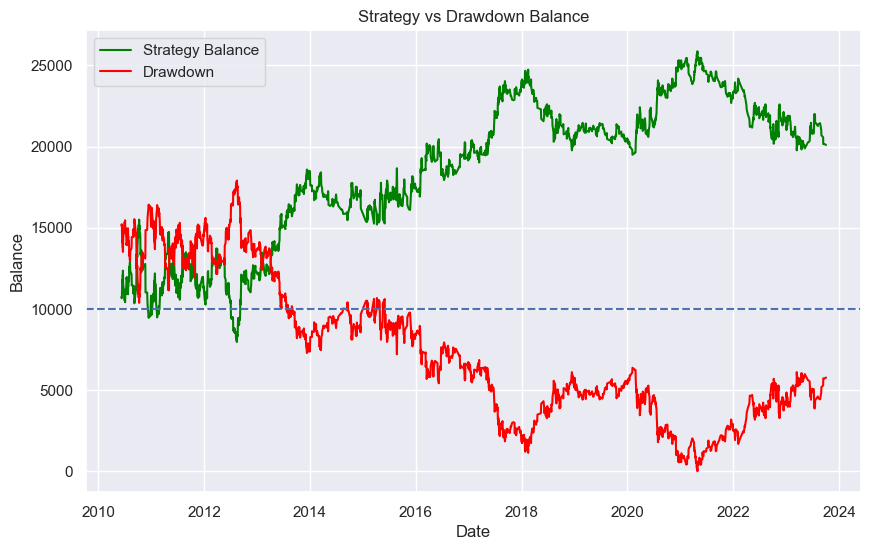

In [43]:

import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
x_values = ndf['time']
y1_values = ndf['Strat_Balance']
y2_values = ndf['StratDrawdown']

# Create a DataFrame (optional, but often convenient)
import pandas as pd
df = pd.DataFrame({'X': x_values, 'Line1': y1_values, 'Line2': y2_values})

# Set the style of seaborn
sns.set(style="darkgrid")
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create a lineplot
sns.lineplot(data=df, x='X', y='Line1', label='Strategy Balance', color= 'green')
sns.lineplot(data=df, x='X', y='Line2', label='Drawdown', color= 'red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Strategy vs Drawdown Balance')

# Show the legend
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=0)

horizontal_line_value = 10000  # Set the value for the horizontal line
plt.axhline(y=horizontal_line_value, color='b', linestyle='--', label='Starting Balance')

# Show the plot
plt.show()

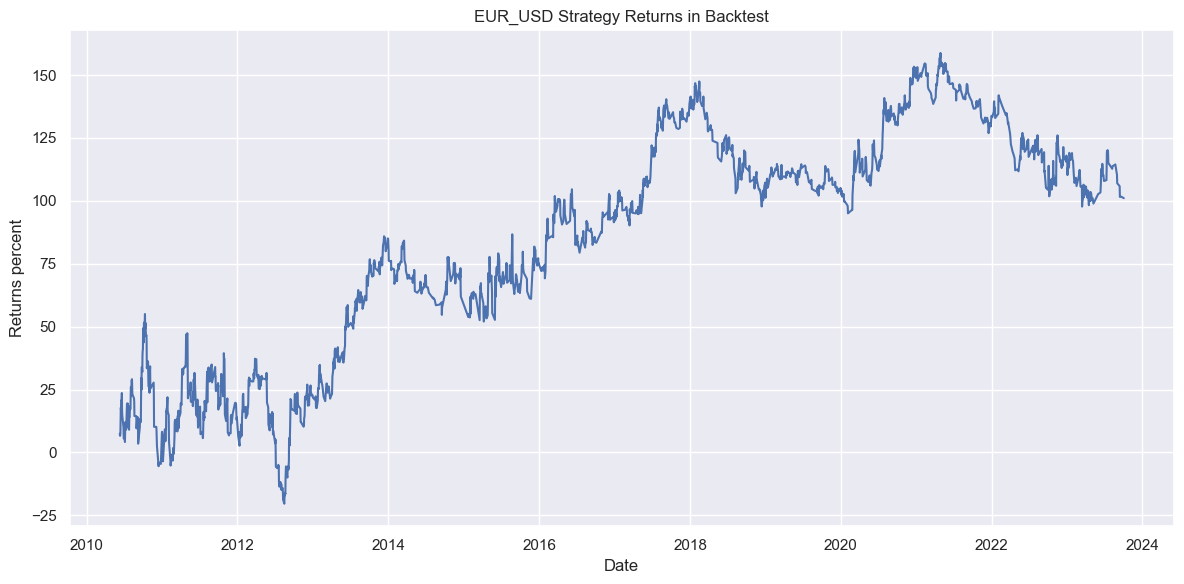

In [44]:

# Create a line chart using Seaborn
plt.figure(figsize=(12, 6))
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y="Strat_Returns_pct", data=ndf)
plt.title("EUR_USD Strategy Returns in Backtest")
plt.xlabel("Date")
plt.ylabel("Returns percent")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

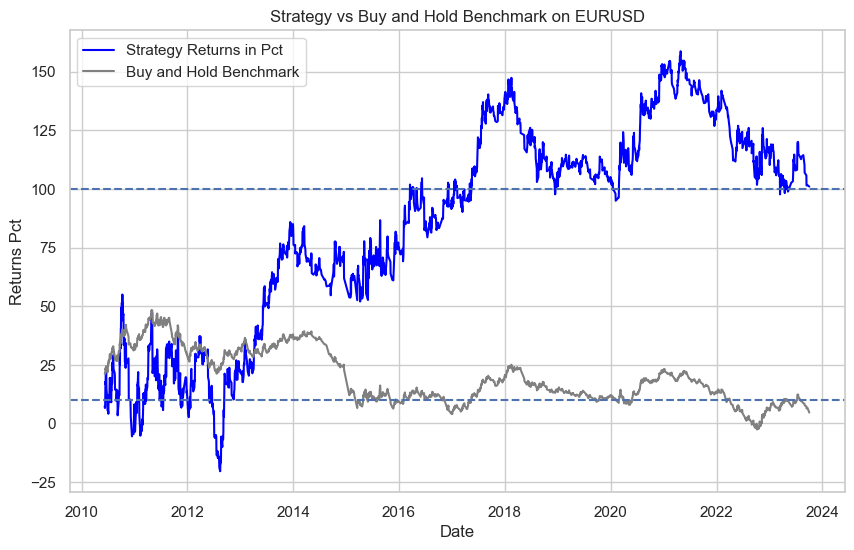

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
x_values = ndf['time']
y1_values = ndf['Strat_Returns_pct']
y2_values = ndf['bhreturnpct']

# Create a DataFrame (optional, but often convenient)
import pandas as pd
df = pd.DataFrame({'X': x_values, 'Line1': y1_values, 'Line2': y2_values})

# Set the style of seaborn
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create a lineplot
sns.lineplot(data=df, x='X', y='Line1', label='Strategy Returns in Pct', color= 'blue'),
sns.lineplot(data=df, x='X', y='Line2', label='Buy and Hold Benchmark', color= 'grey')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Returns Pct')
plt.title('Strategy vs Buy and Hold Benchmark on EURUSD')

# Show the legend
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=0)

horizontal_line_value = 100  # Set the value for the horizontal line
plt.axhline(y=horizontal_line_value, color='b', linestyle='--', label='')

horizontal_line_value2 = 10  # Set the value for the horizontal line
plt.axhline(y=horizontal_line_value2, color='b', linestyle='--', label='')

# Show the plot
plt.show()